# L1 processing OMG Narwhals data - create netCDFs from mooring temp logger (sbe56) data

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import string
import numpy as np
import pandas as pd
import csv
import glob, os
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import xarray as xr
import netCDF4 as nc4
import omg56_funs

## Define output directory

In [3]:
## 2019
output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2019/SBE56/')
## 2020
# output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2020/SBE56/')

In [15]:
## get all filenames and metadata

## 2019
os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56")
metafile = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2019/SBE56_metadata_2019.csv")

## 2020
# os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56")
# metafile = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2020/SBE56_metadata_2020.csv")

cnvfiles = []
for file in glob.glob("*.cnv"):
    cnvfiles.append(file)
pprint(cnvfiles)

## get all metadata associated with each data file
# read in csv with metadata
metadata = pd.read_csv(metafile)
metadata

['SBE05608513_2019-08-06.cnv',
 'SBE05608514_2019-08-03.cnv',
 'SBE05608515_2019-08-05.cnv',
 'SBE05608516_2019-08-03.cnv',
 'SBE05608517_2019-08-04.cnv',
 'SBE05608518_2019-08-03.cnv',
 'SBE05608519_2019-08-04.cnv',
 'SBE05608520_2019-08-03.cnv',
 'SBE05608521_2019-08-06.cnv',
 'SBE05608522_2019-08-05.cnv',
 'SBE05608523_2019-08-03.cnv',
 'SBE05608524_2019-08-05.cnv',
 'SBE05608525_2019-08-03.cnv',
 'SBE05608526_2019-08-04.cnv',
 'SBE05608527_2019-08-05.cnv',
 'SBE05608528_2019-08-06.cnv',
 'SBE05608529_2019-08-03.cnv',
 'SBE05608530_2019-08-04.cnv',
 'SBE05608532_2019-08-04.cnv',
 'SBE05608533_2019-08-05.cnv',
 'SBE05608555_2019-08-04.cnv']


,filename_L0,filename_L1,glacier_front,probe_num,lat,lon,uuid,depth_target,depth_actual,bottom_depth
0,SBE05608516_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608516.nc,Sverdrup glacier,PROBE_1,75.541300,-58.410533,9069f8c8-14dd-11ec-82a8-0242ac130003,140 meters,153 meters,385 meters
1,SBE05608529_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608529.nc,Sverdrup glacier,PROBE_2,75.541300,-58.410533,9069f97c-14dd-11ec-82a8-0242ac130003,180 meters,188 meters,385 meters
2,SBE05608523_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608523.nc,Sverdrup glacier,PROBE_3,75.541300,-58.410533,9069faa8-14dd-11ec-82a8-0242ac130003,220 meters,223 meters,385 meters
3,SBE05608520_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608520.nc,Sverdrup glacier,PROBE_4,75.541300,-58.410533,9069fb66-14dd-11ec-82a8-0242ac130003,260 meters,258 meters,385 meters
4,SBE05608525_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608525.nc,Sverdrup glacier,PROBE_5,75.541300,-58.410533,9069fc88-14dd-11ec-82a8-0242ac130003,300 meters,293 meters,385 meters
5,SBE05608518_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608518.nc,Sverdrup glacier,PROBE_6,75.541300,-58.410533,9069fef4-14dd-11ec-82a8-0242ac130003,320 meters,311 meters,385 meters
6,SBE05608514_2019-08-03.cnv,OMG_Narwhals_Mooring_temp_L1_2019080305608514.nc,Sverdrup glacier,PROBE_7,75.541300,-58.410533,906a00ac-14dd-11ec-82a8-0242ac130003,350 meters,337 meters,385 meters
7,SBE05608530_2019-08-04.cnv,OMG_Narwhals_Mooring_temp_L1_2019080405608530.nc,Kong Oscar glacier,PROBE_8,75.843683,-59.842900,906a0160-14dd-11ec-82a8-0242ac130003,120 meters,123 meters,251 meters
8,SBE05608532_2019-08-04.cnv,OMG_Narwhals_Mooring_temp_L1_2019080405608532.nc,Kong Oscar glacier,PROBE_9,75.843683,-59.842900,906a0214-14dd-11ec-82a8-0242ac130003,140 meters,143 meters,251 meters
9,SBE05608526_2019-08-04.cnv,OMG_Narwhals_Mooring_temp_L1_2019080405608526.nc,Kong Oscar glacier,PROBE_10,75.843683,-59.842900,906a0336-14dd-11ec-82a8-0242ac130003,160 meters,162 meters,251 meters


# **For a single file**

In [16]:
cnvfiles

['SBE05608513_2019-08-06.cnv',
 'SBE05608514_2019-08-03.cnv',
 'SBE05608515_2019-08-05.cnv',
 'SBE05608516_2019-08-03.cnv',
 'SBE05608517_2019-08-04.cnv',
 'SBE05608518_2019-08-03.cnv',
 'SBE05608519_2019-08-04.cnv',
 'SBE05608520_2019-08-03.cnv',
 'SBE05608521_2019-08-06.cnv',
 'SBE05608522_2019-08-05.cnv',
 'SBE05608523_2019-08-03.cnv',
 'SBE05608524_2019-08-05.cnv',
 'SBE05608525_2019-08-03.cnv',
 'SBE05608526_2019-08-04.cnv',
 'SBE05608527_2019-08-05.cnv',
 'SBE05608528_2019-08-06.cnv',
 'SBE05608529_2019-08-03.cnv',
 'SBE05608530_2019-08-04.cnv',
 'SBE05608532_2019-08-04.cnv',
 'SBE05608533_2019-08-05.cnv',
 'SBE05608555_2019-08-04.cnv']

In [25]:
# extract out numbers from the text data lines
data_list =[]

for di, d in enumerate(data_lines):
    # take the line, split against whitespace, convert to numpy array,
    # and convert that array data type from string to float
    tmp = np.array(d.split()).astype('float')
    # append the resulting array to a list
    data_list.append(tmp)

# convert the list of arrays to an array (fast)
data_array = np.array(data_list)

# extract out each variable in the data_array
time = data_array[:,0]
temperature = data_array[:,1]
flag = data_array[:,2]

OMG_Narwhals_Mooring_temp_L1_2019080505608524.nc
number data lines 1390880
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608524'>
SBE56 05608524
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-07-11T23:06:20


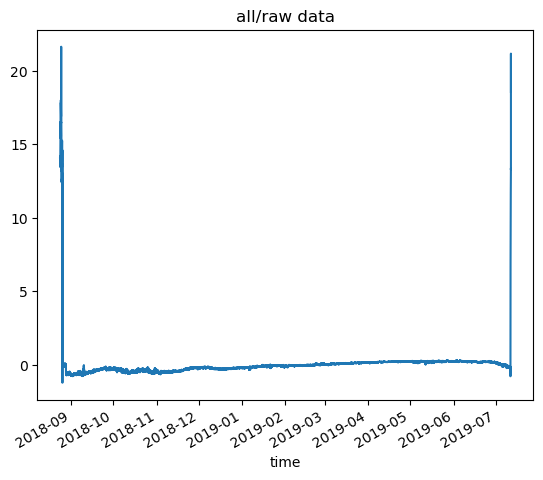

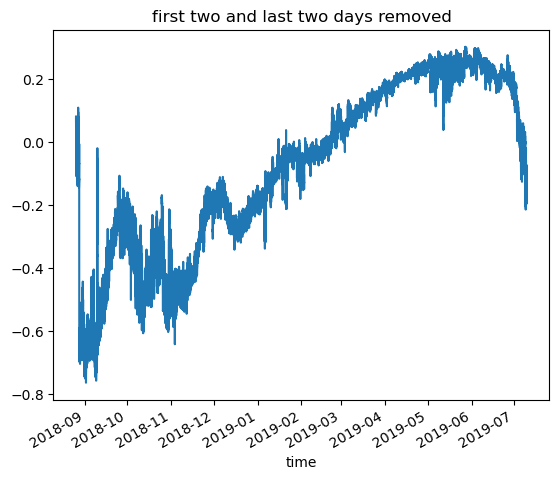

<xarray.Dataset>
Dimensions:      (time: 1390880)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-07-11T23:06:20
Data variables:
    temperature  (time) float64 14.05 14.04 14.04 14.04 ... 17.76 18.51 18.57
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0700-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

In [93]:
## for single cnv file:
filename = 'SBE05608524_2019-08-05.cnv'

# extract metadata
data = metadata.loc[metadata['filename_L0'] == filename] # select row for cnv file 'filename'
glacier_front = data.glacier_front.values[0]
probe_num = data.probe_num.values[0]
lat = data.lat.values[0]
lon = data.lon.values[0]
bottom_depth = data.bottom_depth.values[0]

## =================== COMMENT OUT LINE FOR DESIRED FILE PATH - 2019 OR 2020 =================== ##
file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56/" + filename) # 2019
# file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56/" + filename) # 2020

uuid = data.uuid.values[0]
depth_target = data.depth_target.values[0]
depth_actual = data.depth_actual.values[0]

## =================== COMMENT OUT LINE FOR DESIRED YEAR - 2019 OR 2020 =================== ##
netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_201908' + filename[20:22] + filename[3:11] + '.nc' # 2019
# netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_20200806' + filename[3:11] + '.nc' # 2020
print(netcdf_filename)

## extract data, create dataset, and add metadata
data_lines, device_type, serial_number, start_time_dt64, start_date, sample_interval_plain, sample_interval_td64, var_names = omg56_funs.open_omg_file(file)
mooring_ds = omg56_funs.create_Dataset(data_lines, start_time_dt64, sample_interval_td64, glacier_front, probe_num)
mooring_ds = omg56_funs.add_metadata(mooring_ds, uuid, lat, lon, glacier_front, bottom_depth, depth_target, depth_actual, netcdf_filename, start_date, sample_interval_plain, serial_number, device_type, probe_num)

## Create NetCDF variable encoding (required to save the time values properly)
new_encoding = omg56_funs.create_encoding(mooring_ds)

## Save xarray DataSet object as netcdf
num_times = len(mooring_ds.time)

# 2019
if glacier_front=='Sverdrup glacier':
    mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-24","2019-08-03")) 
elif glacier_front=='Kong Oscar glacier':
    mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-25","2019-08-04"))
elif probe_num == 'PROBE_14':
    mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-07-10"))
else: mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-08-05"))

# # 2019 data
# if '2018' in str(start_time_dt64):
#     ## truncate the last measurement times since those are on the deck
#     # if else statement to truncate data according to each fjord
#     if glacier_front == 'Sverdrup glacier':
#         mooring_ds_truncated = mooring_ds.isel(time=range(0,num_times-4320))
#     elif glacier_front == 'Kong Oscar glacier':
#         mooring_ds_truncated = mooring_ds.isel(time=range(4320,num_times-4320))
#     elif probe_num == 'PROBE_14':
#         mooring_ds_truncated = mooring_ds.isel(time=range(8640,num_times-8640))
#     else: # Rink
#         mooring_ds_truncated = mooring_ds.isel(time=range(0,num_times-8640))
        
# # 2020 data
# if '2019' in str(start_time_dt64):
#     mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-06","2020-08-09")) # truncate to day before recovery of moorings
        
netcdf_filename = Path(netcdf_filename)
mooring_ds_truncated.to_netcdf(output_dir / netcdf_filename,encoding=new_encoding)
mooring_ds_truncated.close()

# **The master loop**

OMG_Narwhals_Mooring_temp_L1_2019080605608513.nc
number data lines 1494664
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608513'>
SBE56 05608513
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T23:41:00


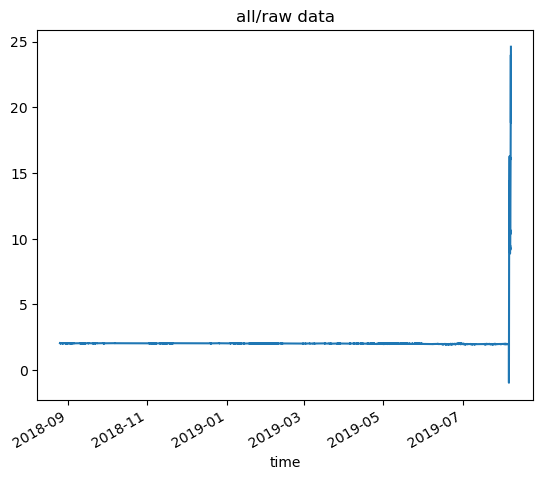

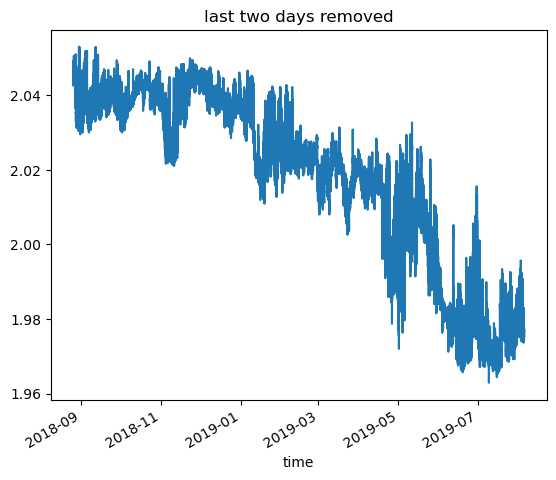

<xarray.Dataset>
Dimensions:      (time: 1494664)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-06T23:41:00
Data variables:
    temperature  (time) float64 2.048 2.047 2.047 2.047 ... 24.19 24.41 24.61
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0d18-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608514.nc
number data lines 1492085
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608514'>
SBE56 05608514
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T18:21:20


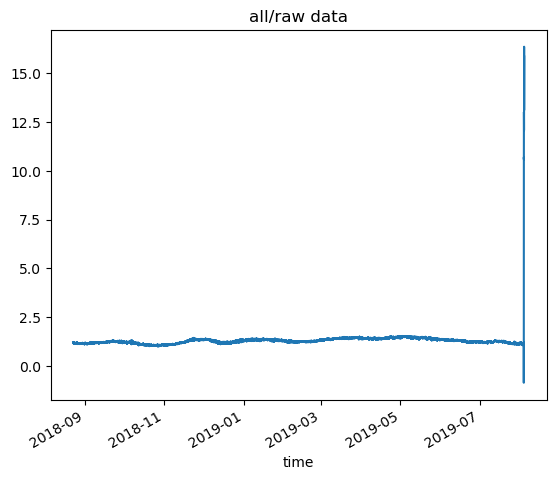

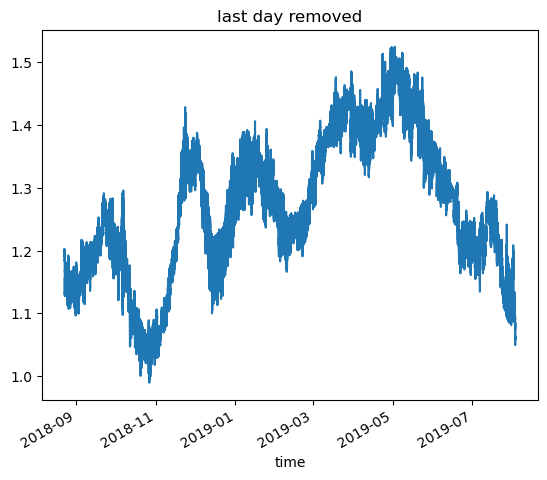

<xarray.Dataset>
Dimensions:      (time: 1492085)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T18:...
Data variables:
    temperature  (time) float64 1.202 1.201 1.202 1.202 ... 15.53 15.7 15.87
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a00ac-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080505608515.nc
number data lines 1490358
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608515'>
SBE56 05608515
2018-08-26T00:01:13
before
[238.000845 238.001076 238.001308 238.001539 238.001771]

after
[numpy.datetime64('2018-08-26T00:01:13'),
 numpy.datetime64('2018-08-26T00:01:33'),
 numpy.datetime64('2018-08-26T00:01:53'),
 numpy.datetime64('2018-08-26T00:02:13'),
 numpy.datetime64('2018-08-26T00:02:33')]
recording start time:  2018-08-26T00:01:13
recording end time:  2019-08-05T23:46:53


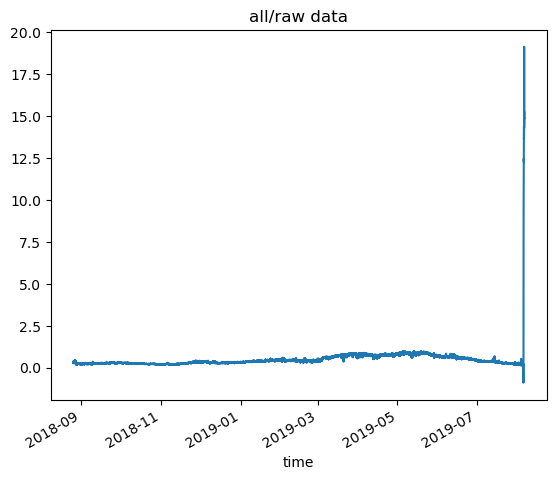

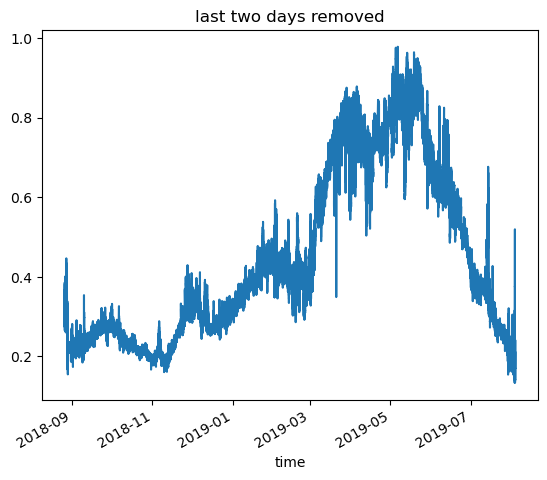

<xarray.Dataset>
Dimensions:      (time: 1490358)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26T00:01:13 ... 2019-08-05T23:...
Data variables:
    temperature  (time) float64 0.2849 0.285 0.2852 0.2854 ... 14.73 14.27 14.82
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a07b4-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608516.nc
number data lines 1490928
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608516'>
SBE56 05608516
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T11:55:40


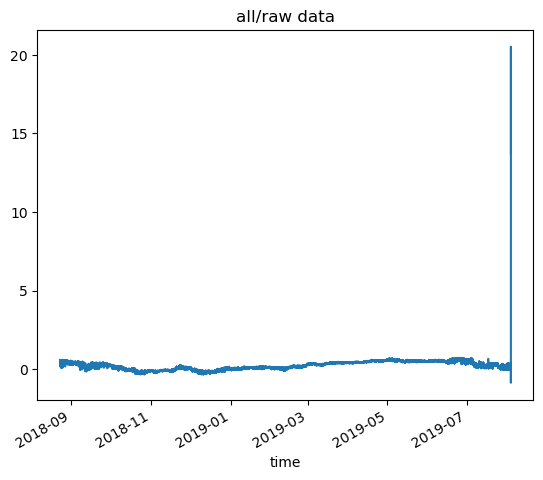

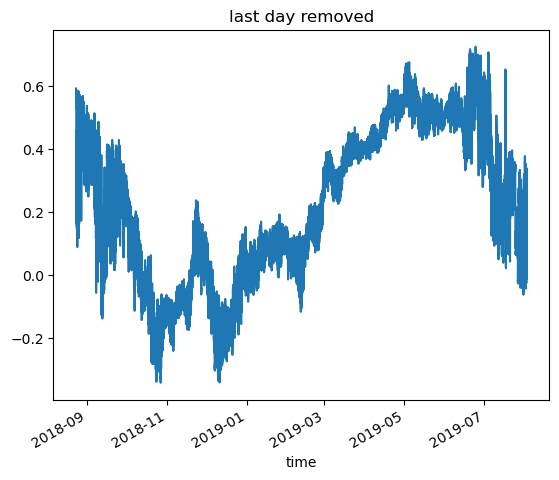

<xarray.Dataset>
Dimensions:      (time: 1490928)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T11:...
Data variables:
    temperature  (time) float64 0.5789 0.5783 0.5792 0.5806 ... 12.59 13.13 13.7
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069f8c8-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080405608517.nc
number data lines 1494391
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608517'>
SBE56 05608517
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T22:10:00


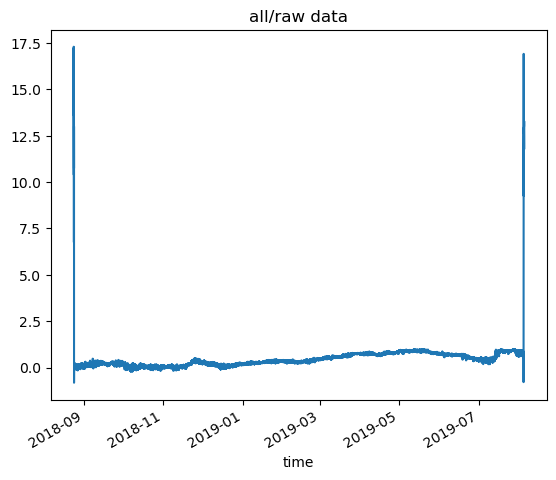

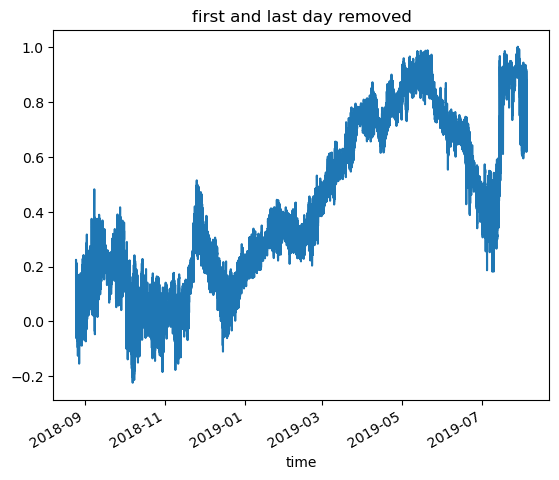

<xarray.Dataset>
Dimensions:      (time: 1494391)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-04T22:10:00
Data variables:
    temperature  (time) float64 14.5 14.47 14.48 14.49 ... 13.07 13.06 13.05
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a03f4-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608518.nc
number data lines 1491925
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608518'>
SBE56 05608518
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T17:28:00


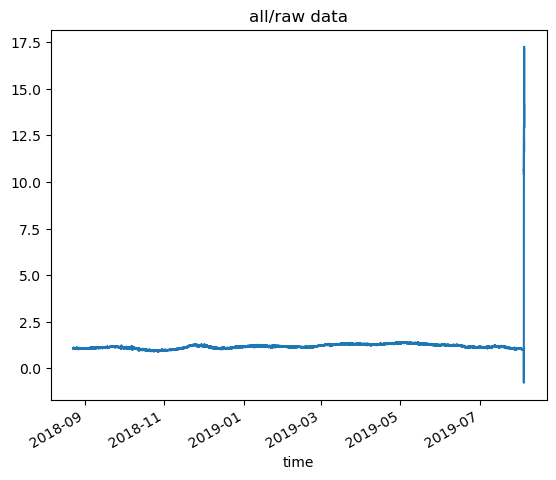

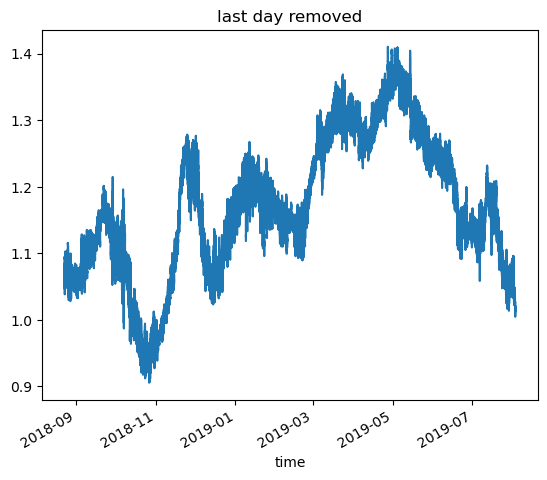

<xarray.Dataset>
Dimensions:      (time: 1491925)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T17:...
Data variables:
    temperature  (time) float64 1.092 1.092 1.093 1.092 ... 14.35 14.67 14.12
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069fef4-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080405608519.nc
number data lines 1494502
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608519'>
SBE56 05608519
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T22:47:00


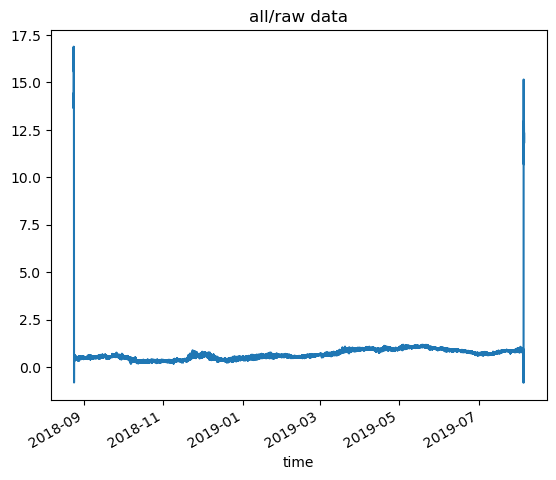

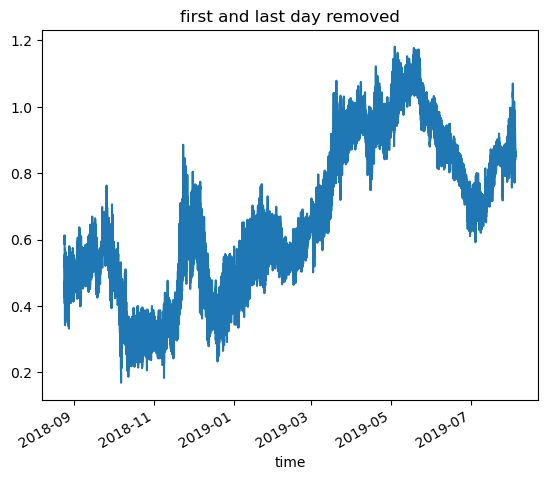

<xarray.Dataset>
Dimensions:      (time: 1494502)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-04T22:47:00
Data variables:
    temperature  (time) float64 14.28 14.27 14.27 14.27 ... 12.19 12.24 12.29
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0642-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608520.nc
number data lines 1491304
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608520'>
SBE56 05608520
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T14:01:00


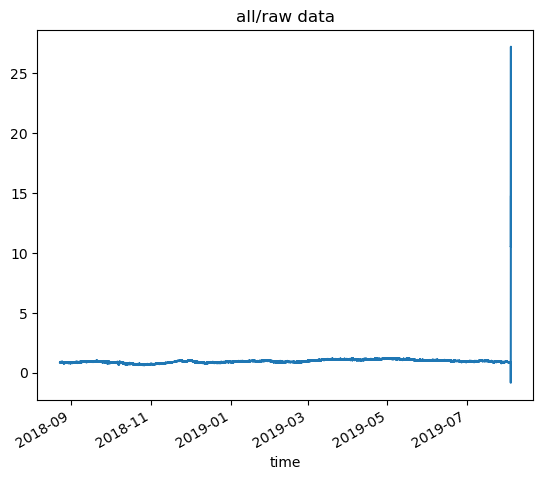

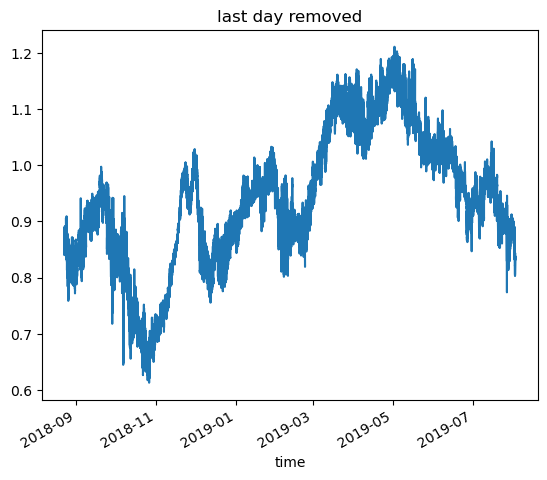

<xarray.Dataset>
Dimensions:      (time: 1491304)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T14:...
Data variables:
    temperature  (time) float64 0.8559 0.8561 0.8554 ... 11.63 13.69 14.69
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069fb66-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080605608521.nc
number data lines 1494441
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608521'>
SBE56 05608521
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T22:26:40


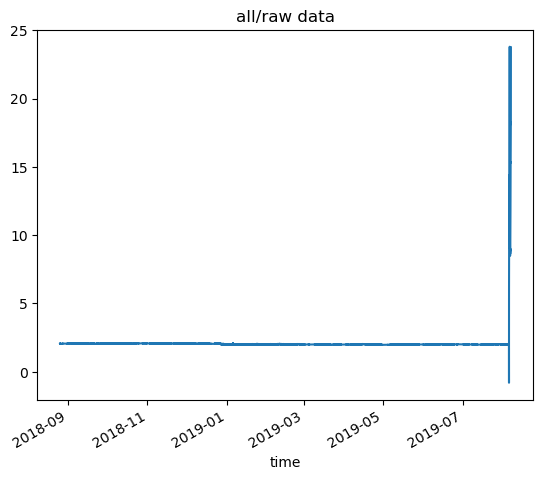

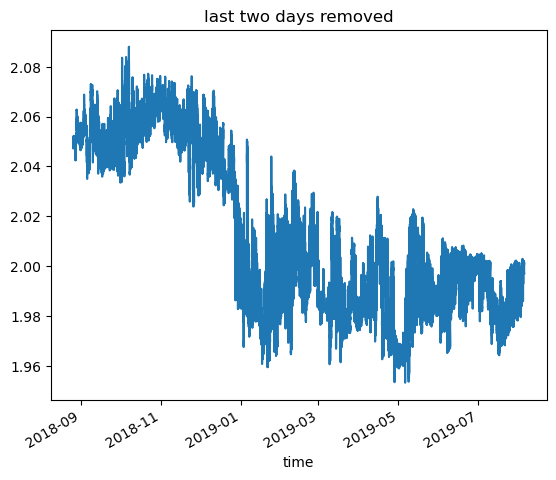

<xarray.Dataset>
Dimensions:      (time: 1494441)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-06T22:26:40
Data variables:
    temperature  (time) float64 2.048 2.048 2.048 2.048 ... 23.72 23.73 23.75
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0b2e-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080505608522.nc
number data lines 1490445
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608522'>
SBE56 05608522
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T00:14:40


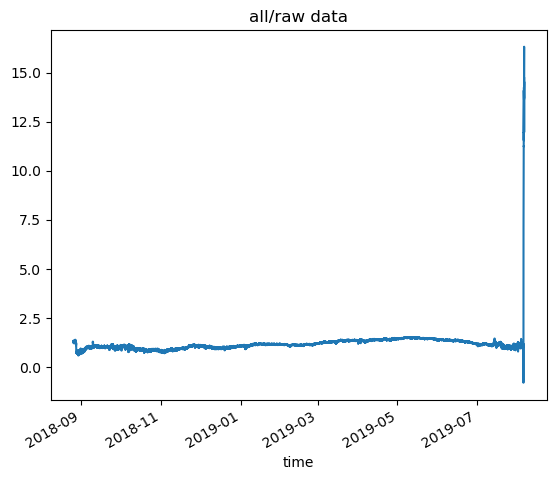

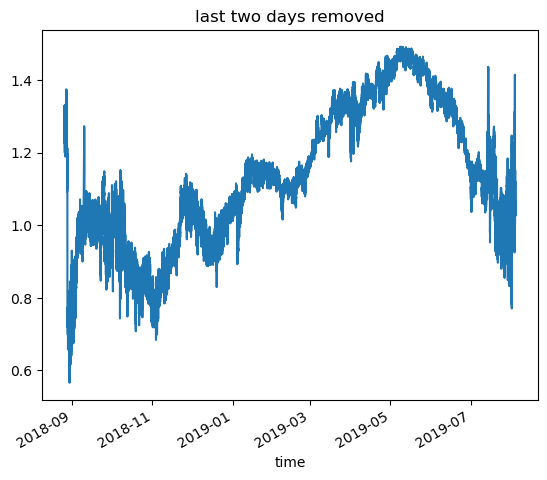

<xarray.Dataset>
Dimensions:      (time: 1490445)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-06T00:14:40
Data variables:
    temperature  (time) float64 1.305 1.306 1.306 1.306 ... 14.44 14.64 14.71
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0868-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608523.nc
number data lines 1491201
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608523'>
SBE56 05608523
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T13:26:40


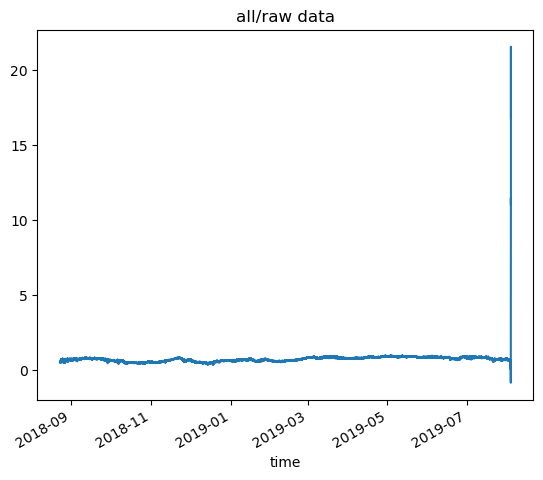

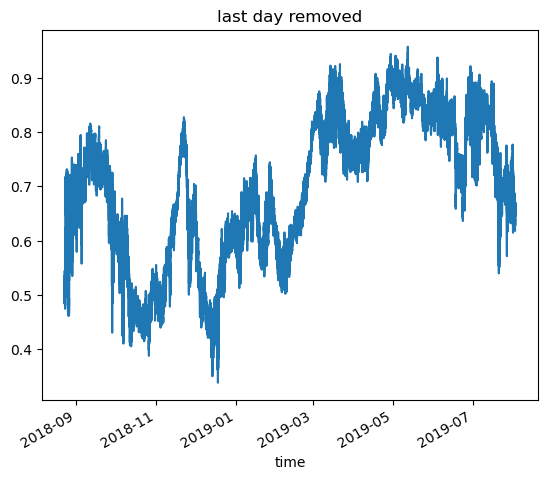

<xarray.Dataset>
Dimensions:      (time: 1491201)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T13:...
Data variables:
    temperature  (time) float64 0.5145 0.5137 0.5142 0.5139 ... 16.21 16.52 16.8
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069faa8-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080505608524.nc
number data lines 1390880
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608524'>
SBE56 05608524
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-07-11T23:06:20


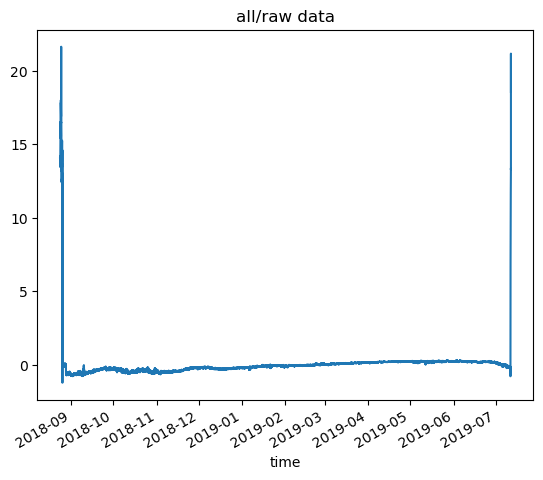

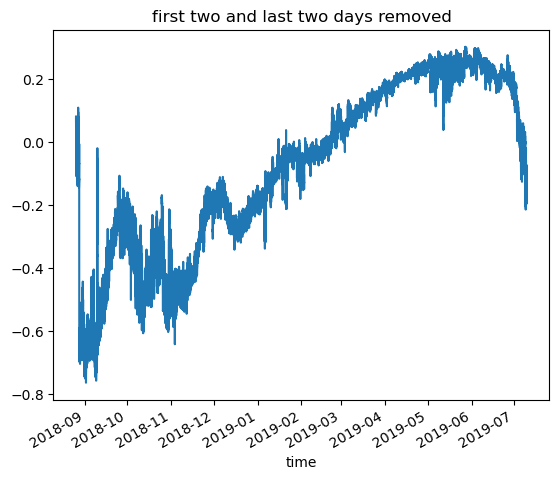

<xarray.Dataset>
Dimensions:      (time: 1390880)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-07-11T23:06:20
Data variables:
    temperature  (time) float64 14.05 14.04 14.04 14.04 ... 17.76 18.51 18.57
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0700-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608525.nc
number data lines 1492015
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608525'>
SBE56 05608525
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T17:58:00


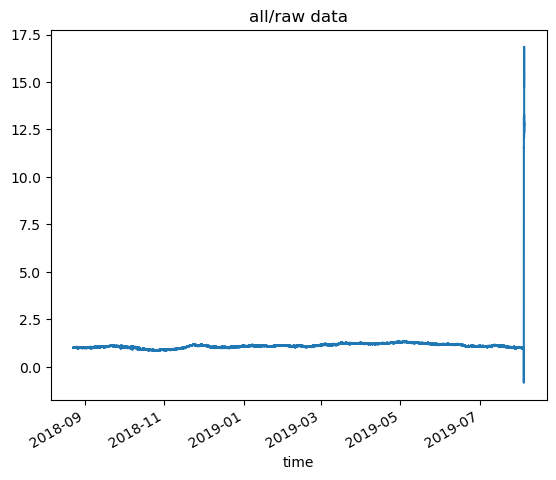

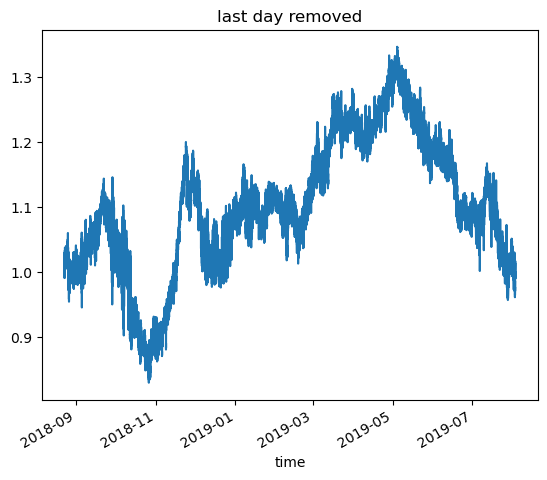

<xarray.Dataset>
Dimensions:      (time: 1492015)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T17:...
Data variables:
    temperature  (time) float64 0.998 1.001 1.0 0.9979 ... 14.53 14.57 14.76
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069fc88-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080405608526.nc
number data lines 1494281
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608526'>
SBE56 05608526
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T21:33:20


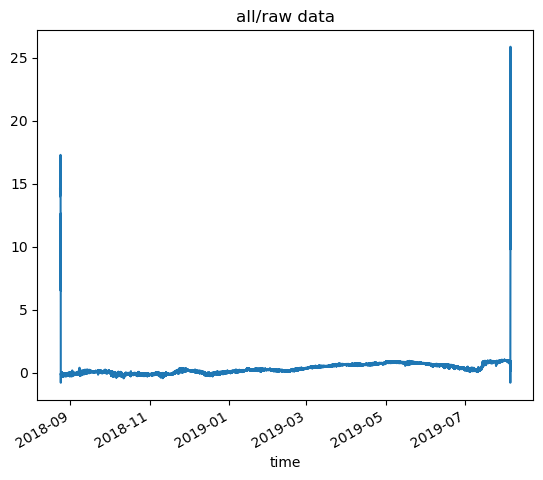

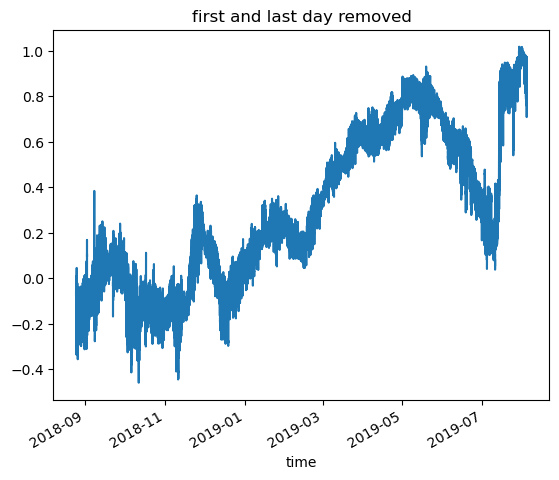

<xarray.Dataset>
Dimensions:      (time: 1494281)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-04T21:33:20
Data variables:
    temperature  (time) float64 14.61 14.61 14.61 14.61 ... 12.29 12.44 12.6
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0336-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080505608527.nc
number data lines 1490586
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608527'>
SBE56 05608527
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T01:01:40


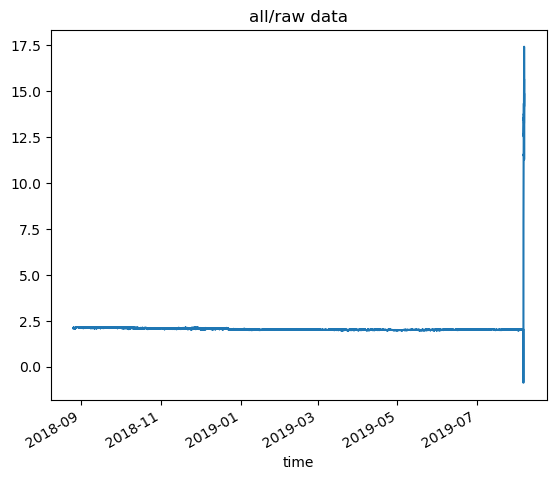

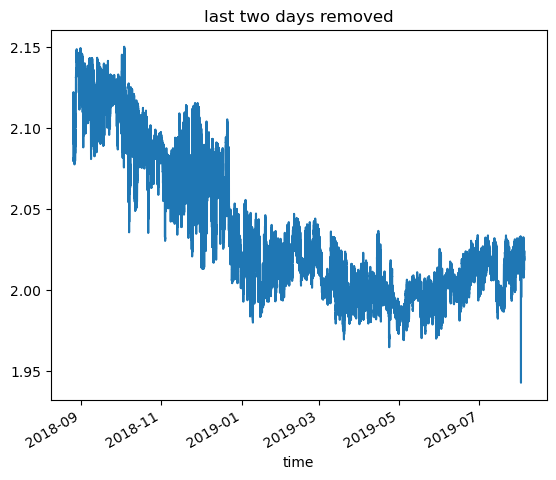

<xarray.Dataset>
Dimensions:      (time: 1490586)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-06T01:01:40
Data variables:
    temperature  (time) float64 2.081 2.081 2.081 2.081 ... 14.16 14.22 14.21
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0a70-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080605608528.nc
number data lines 1494725
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608528'>
SBE56 05608528
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-07T00:01:20


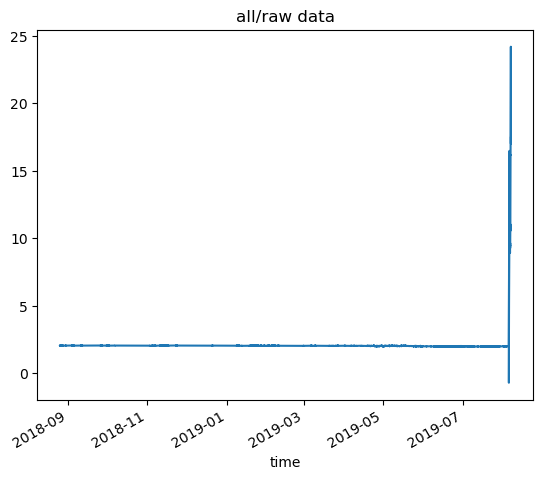

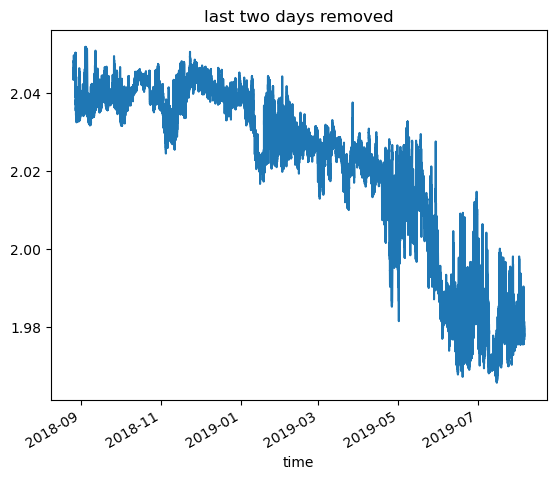

<xarray.Dataset>
Dimensions:      (time: 1494725)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-07T00:01:20
Data variables:
    temperature  (time) float64 2.046 2.046 2.046 2.046 ... 17.02 17.22 17.44
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0e94-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080305608529.nc
number data lines 1491116
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608529'>
SBE56 05608529
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T12:58:20


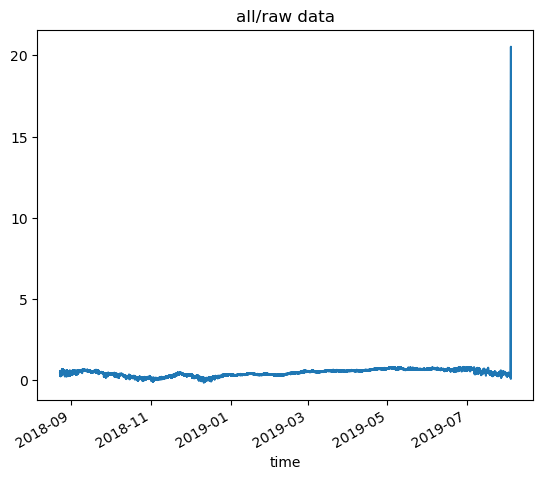

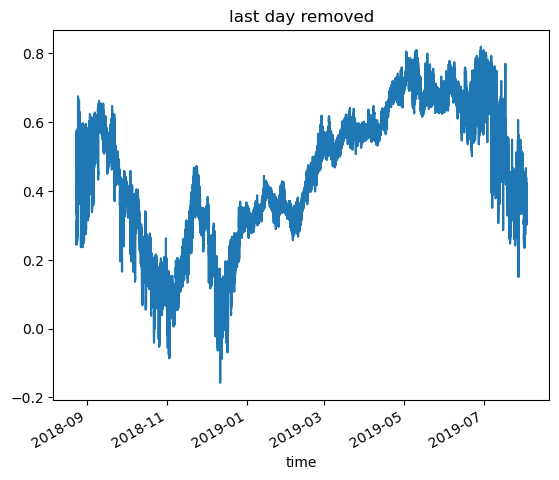

<xarray.Dataset>
Dimensions:      (time: 1491116)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-23T09:00:00 ... 2019-08-03T12:...
Data variables:
    temperature  (time) float64 0.4306 0.4305 0.432 0.4334 ... 16.68 16.96 17.19
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069f97c-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080405608530.nc
number data lines 1493968
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608530'>
SBE56 05608530
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T19:49:00


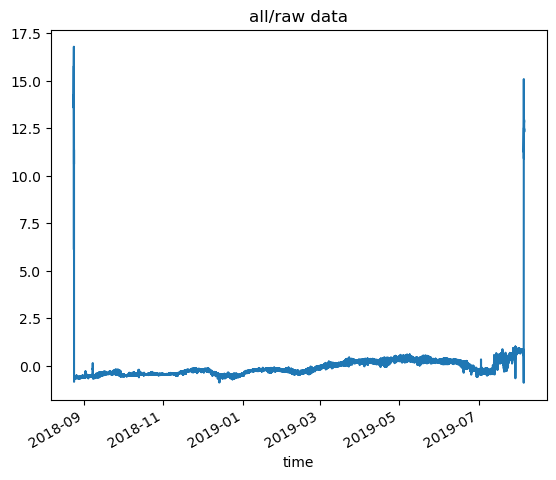

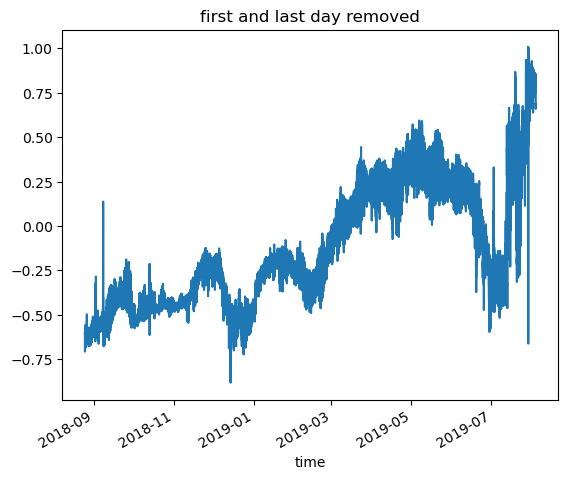

<xarray.Dataset>
Dimensions:      (time: 1493968)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-04T19:49:00
Data variables:
    temperature  (time) float64 14.17 14.17 14.17 14.17 ... 12.46 12.41 12.34
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0160-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080405608532.nc
number data lines 1494035
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608532'>
SBE56 05608532
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T20:11:20


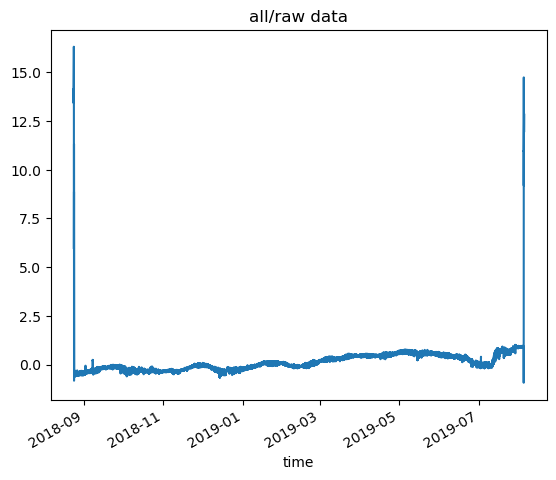

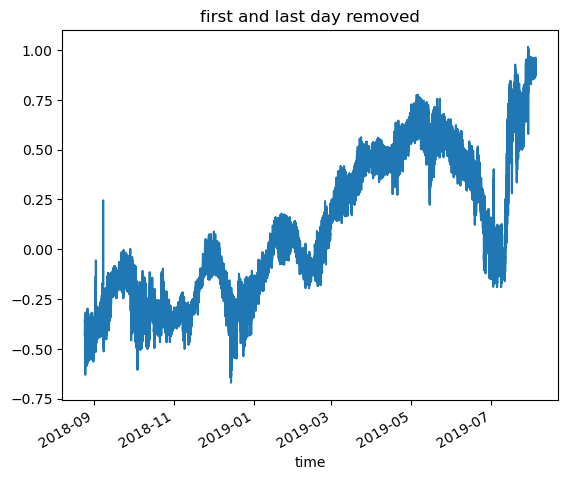

<xarray.Dataset>
Dimensions:      (time: 1494035)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-04T20:11:20
Data variables:
    temperature  (time) float64 14.04 14.04 14.04 14.04 ... 12.36 12.15 11.98
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0214-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080505608533.nc
number data lines 1490488
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608533'>
SBE56 05608533
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T00:29:00


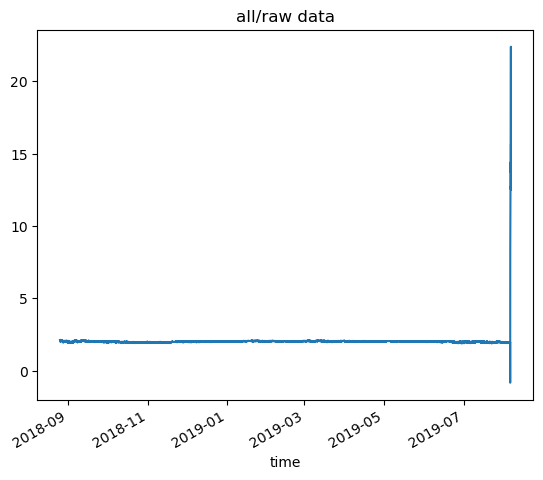

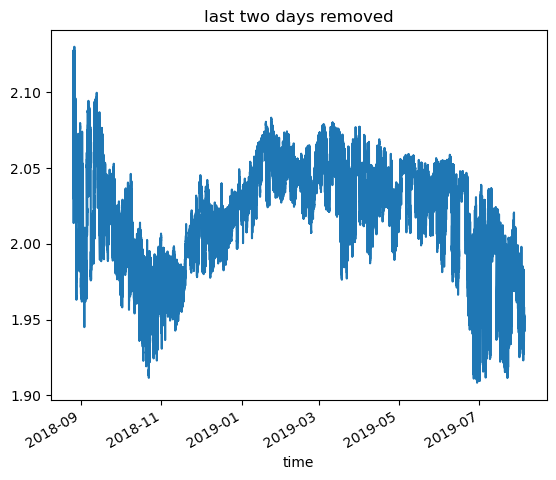

<xarray.Dataset>
Dimensions:      (time: 1490488)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-06T00:29:00
Data variables:
    temperature  (time) float64 2.125 2.125 2.125 2.125 ... 15.02 14.84 15.62
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0980-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

OMG_Narwhals_Mooring_temp_L1_2019080405608555.nc
number data lines 1494437
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608555'>
SBE56 05608555
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T22:25:20


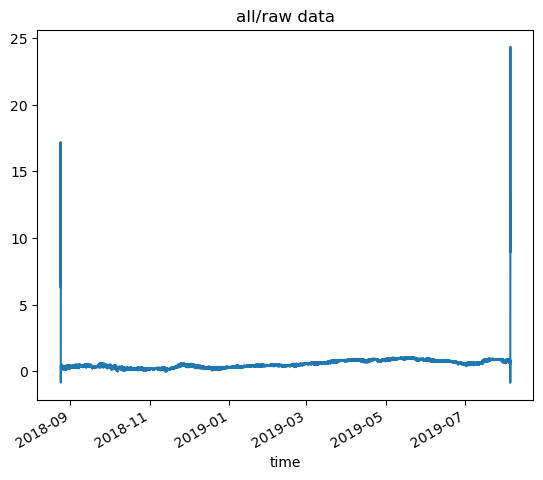

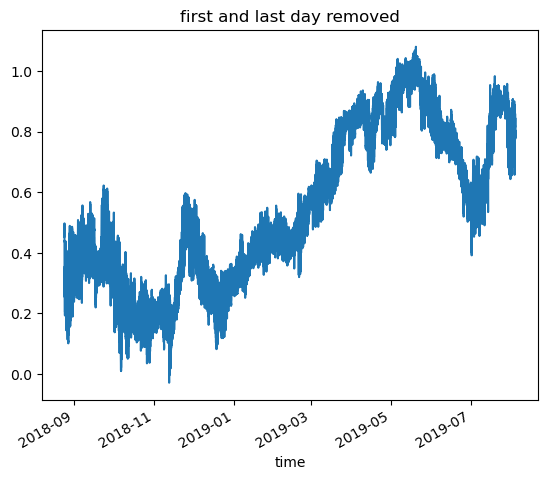

<xarray.Dataset>
Dimensions:      (time: 1494437)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-04T22:25:20
Data variables:
    temperature  (time) float64 14.33 14.32 14.33 14.33 ... 12.06 12.28 12.46
    flag         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a04f8-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

In [11]:
## create a loop that uses the above functions for all mooring data files
## loop through cnvfiles object

for filename in cnvfiles:
    # extract metadata
    data = metadata.loc[metadata['filename_L0'] == filename] # select row for cnv file 'filename'
    glacier_front = data.glacier_front.values[0]
    probe_num = data.probe_num.values[0]
    lat = data.lat.values[0]
    lon = data.lon.values[0]
    bottom_depth = data.bottom_depth.values[0]
    
    ## =================== COMMENT OUT LINE FOR DESIRED YEAR - 2019 OR 2020 =================== ##
    file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56/" + filename) # 2019
    # file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56/" + filename) # 2020

    uuid = data.uuid.values[0]
    depth_target = data.depth_target.values[0]
    depth_actual = data.depth_actual.values[0]
    
    ## =================== COMMENT OUT LINE FOR DESIRED YEAR - 2019 OR 2020 =================== ##
    netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_201908' + filename[20:22] + filename[3:11] + '.nc' # 2019
    # netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_20200806' + filename[3:11] + '.nc' # 2020
    print(netcdf_filename)
    
    ## extract data, create dataset, and add metadata
    data_lines, device_type, serial_number, start_time_dt64, start_date, sample_interval_plain, sample_interval_td64, var_names = omg56_funs.open_omg_file(file)
    mooring_ds = omg56_funs.create_Dataset(data_lines, start_time_dt64, sample_interval_td64, glacier_front, probe_num)
    mooring_ds = omg56_funs.add_metadata(mooring_ds, uuid, lat, lon, glacier_front, bottom_depth, depth_target, depth_actual, netcdf_filename, start_date, sample_interval_plain, serial_number, device_type, probe_num)

    ## Create NetCDF variable encoding (required to save the time values properly)
    new_encoding = omg56_funs.create_encoding(mooring_ds)
    
    ## Save xarray DataSet object as netcdf
    num_times = len(mooring_ds.time)
    
    # # 2019 data
    # if '2018' in str(start_time_dt64):
    #     ## truncate the last measurement times since those are on the deck
    #     # if else statement to truncate data according to each fjord
    #     if glacier_front == 'Sverdrup glacier':
    #         mooring_ds_truncated = mooring_ds.isel(time=range(0,num_times-4320)) # remove last day
    #     elif glacier_front == 'Kong Oscar glacier':
    #         mooring_ds_truncated = mooring_ds.isel(time=range(4320,num_times-4320)) # remove first and last day
    #     elif probe_num == 'PROBE_14':
    #         mooring_ds_truncated = mooring_ds.isel(time=range(8640,num_times-8640)) # remove first and last two days
    #     else: # Rink
    #         mooring_ds_truncated = mooring_ds.isel(time=range(0,num_times-8640)) # remove last two days     
    # # 2020 data
    # if '2019' in str(start_time_dt64):
    #     mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-06","2020-08-09")) # truncate to day before recovery of moorings
    
    # 2019
    if glacier_front=='Sverdrup glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-24","2019-08-03")) 
    elif glacier_front=='Kong Oscar glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-25","2019-08-04"))
    elif probe_num == 'PROBE_14':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-07-11"))
    else: mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-08-05"))
    
    # 2020
    # if glacier_front=='Kong Oscar glacier':
    #     mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-04T14","2020-08-10T09")) 
    # else: mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-05T20","2020-08-10T09"))
    
    netcdf_filename = Path(netcdf_filename)
    mooring_ds_truncated.to_netcdf(output_dir / netcdf_filename,encoding=new_encoding)
    mooring_ds_truncated.close()

## Check the file

In [5]:
netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_2019080505608522.nc'

In [6]:
tmp = xr.open_dataset(output_dir / netcdf_filename)
tmp.close()

In [7]:
tmp

<xarray.Dataset>
Dimensions:      (time: 1490400)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-05T23:59:40
Data variables:
    temperature  (time) float64 ...
    flag         (time) float64 ...
Attributes: (12/42)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0868-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group